MNE : From raw data to epochs and evoked responses (ERF/ERP)
============================================================

`
Authors:
Alexandre Gramfort
Denis A. Engemann
Jona Sassenhagen
`

In [2]:
# add plot inline in the page
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

First, load the mne package:

In [3]:
import mne
mne.pick_types?

We set the log-level to 'warning' so the output is less verbose

In [4]:
mne.set_log_level('warning')

## Access raw data

Now we import the sample dataset. If you don't already have it, it will be downloaded automatically (but be patient approx. 2GB)

In [5]:
from mne.datasets import sample
# also explore other datasets, e.g. mne.datasets.XXX
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
print(raw_fname)

/Users/dengemann/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif


In [6]:
print(raw_fname)

/Users/dengemann/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif


Read data from file:

In [7]:
raw = mne.io.Raw(raw_fname, preload=False)

print(raw)

<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec)>


In [8]:
raw.ch_names[315:315 + 3]

[u'EEG 001', u'EEG 002', u'EEG 003']

In [9]:
# print raw.info
print(raw.proj)

False


Look at the channels in raw:

In [10]:
print(raw.ch_names[:5])

[u'MEG 0113', u'MEG 0112', u'MEG 0111', u'MEG 0122', u'MEG 0123']


In [11]:
data, times = raw[:, :10]  # fetch all channels and the first 10 time points
print(data.shape)

(376, 10)


# plotting the hard way

Read and plot a segment of raw data

In [12]:
start, stop = raw.time_as_index([100, 115])  # 100 s to 115 s data segment
data, times = raw[:306, start:stop]
print(data.shape, times.shape, times.min(), times.max())

((306, 2252), (2252,), 99.997504185773124, 114.98880501309083)


Take some magnetometer data and plot it

In [13]:
picks = mne.pick_types(raw.info, meg='mag', exclude=[])
print(picks)

[  2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53
  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 101 104 107
 110 113 116 119 122 125 128 131 134 137 140 143 146 149 152 155 158 161
 164 167 170 173 176 179 182 185 188 191 194 197 200 203 206 209 212 215
 218 221 224 227 230 233 236 239 242 245 248 251 254 257 260 263 266 269
 272 275 278 281 284 287 290 293 296 299 302 305]


In [14]:
import matplotlib.pyplot as plt

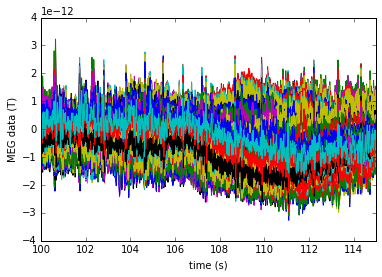

In [15]:
plt.plot(times, data[picks].T)  # T for transpose
plt.xlim(times[0], times[-1])
plt.xlabel('time (s)')
plt.ylabel('MEG data (T)');  # the ; is an IPython directive, not needed as in MATLAB


# ... or use MNE plotters

In [16]:
%matplotlib

raw.plot();

Using matplotlib backend: MacOSX


In [17]:
raw.info['bads']

[u'MEG 2443', u'EEG 053']

Save a segment of 150s of raw data (MEG only):

In [20]:
# let's be more picky
picks_meg = mne.pick_types(raw.info, meg=True, eeg=False, eog=False,
                           stim=False, exclude='bads')
# we start by looking at magnetometer and gradiometer signals

In [21]:
raw.save('sample_audvis_meg_raw.fif', tmin=0., tmax=150., picks=picks_meg, overwrite=True)

Filtering:

In [22]:
raw_beta = mne.io.Raw(raw_fname, preload=True)  # reload data with preload for filtering

# keep beta band
raw_beta.filter(13.0, 30.0, method='iir', picks=picks_meg)

# save the result
raw_beta.save('sample_audvis_beta_raw.fif', overwrite=True)

print(raw_beta.info)

<Info | 20 non-empty fields
    bads : list | MEG 2443, EEG 053
    buffer_size_sec : numpy.float64 | 13.3196808772
    ch_names : 'mne.io.meas_info._ChannelNameList | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : list | 376 items (EOG: 1, EEG: 60, STIM: 9, GRAD: 204, MAG: 102)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    dig : list | 146 items
    events : list | 0 items
    file_id : dict | 4 items
    filename : unicode | /Users/den.../sample_audvis_filt-0-40_raw.fif
    highpass : float | 0.10000000149 Hz
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 40.0 Hz
    meas_date : numpy.ndarray | 2002-12-03 20:01:10
    meas_id : dict | 4 items
    nchan : int | 376
    projs : list | PCA-v1: off, PCA-v2: off, PCA-v3: off, ...
    sfreq : float | 150.153747559 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : Non

## Exercise :

- Filter the raw data between 1Hz and 40Hz. Observe the absence of the slow drifts.
- Plot the magnetometers and the gradiometers separately. Observe the different units.

## Define and read epochs

First extract events:

In [23]:
events = mne.find_events(raw, stim_channel='STI 014')

In [24]:
# See parameters to fine tune event detection, e.g. consecutive non-zero
# mne.find_events?

In [25]:
print(events[:5])  # events is a 2d array, (time, previous, trigger)

[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


In [26]:
len(events[events[:, 2] == 2])

73

In [27]:
len(events)

319

Where are they coming from?

In [28]:
d, t = raw[raw.ch_names.index('STI 014'), :]
d.shape

(1, 41700)

In [29]:
raw.ch_names.index('STI 014')

312

In [31]:
raw = mne.io.Raw(raw_fname, preload=True)  # reload data with preload for filtering
raw.filter(1, 40, method='iir', picks=picks_meg)

<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec)>

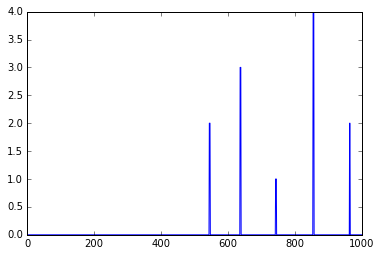

In [34]:
%matplotlib inline
plt.plot(d[0,:1000]);

Events are stored as 2D numpy array where the first column is the time instant and the last one is the event number. It is therefore easy to manipulate.

In [35]:
events_new = events.copy()
events_new[events_new[:, 2] == 2, 2] = 1  # MATLAB- and R-like syntax
events_new[events_new[:, 2] == 4, 2] = 3
print(events_new[:5])
print(events[:5])

[[6994    0    1]
 [7086    0    3]
 [7192    0    1]
 [7304    0    3]
 [7413    0    1]]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


For event trigger and conditions we use a Python dictionary with keys that contain "/" for grouping sub-conditions

event 5 missing from event_id will be ignored
event 32 missing from event_id will be ignored


/Users/dengemann/anaconda/envs/mnedev/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: event 5 missing from event_id will be ignored
  app.launch_new_instance()
/Users/dengemann/anaconda/envs/mnedev/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: event 32 missing from event_id will be ignored
  app.launch_new_instance()


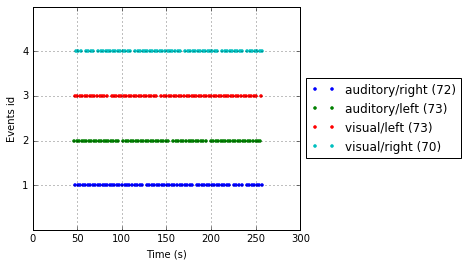

In [39]:
event_id = {"visual/left": 3, "visual/right": 4, "auditory/right": 1, "auditory/left": 2}

fig = mne.viz.plot_events(events, raw.info['sfreq'], event_id=event_id);

Define epochs parameters:

In [40]:
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)

Define the baseline period:

In [45]:
baseline = (None, 0)  # means from the first instant to t = 0

Define peak-to-peak (amplitude range) rejection parameters for gradiometers, magnetometers and EOG:

In [43]:
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)  # this can be highly data dependent

In [47]:
# we re picky again, this time with EOG
picks_meg = mne.pick_types(raw.info, meg=True, eeg=False, eog=True,
                           stim=False, exclude='bads')
# we start by looking at magnetometer and gradiometer signals

Read epochs:

In [48]:
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks_meg, baseline=baseline, reject=reject)

In [50]:
print(epochs)

<Epochs  |  n_events : 288 (good & bad), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : (None, 0),
 'auditory/left': 73, 'auditory/right': 72, 'visual/left': 73, 'visual/right': 70>


Explore the epochs namespace

Hit ``epochs.<TAB>``

# The epochs object is your MNE swiss army knife for processing segmented data!

- specialized methods for diagnostic plotting of data
- averaging
- saving
- manipulating data, e.g., rearranging or deleting single trials, resampling

more MNE plotters ...

Using matplotlib backend: MacOSX


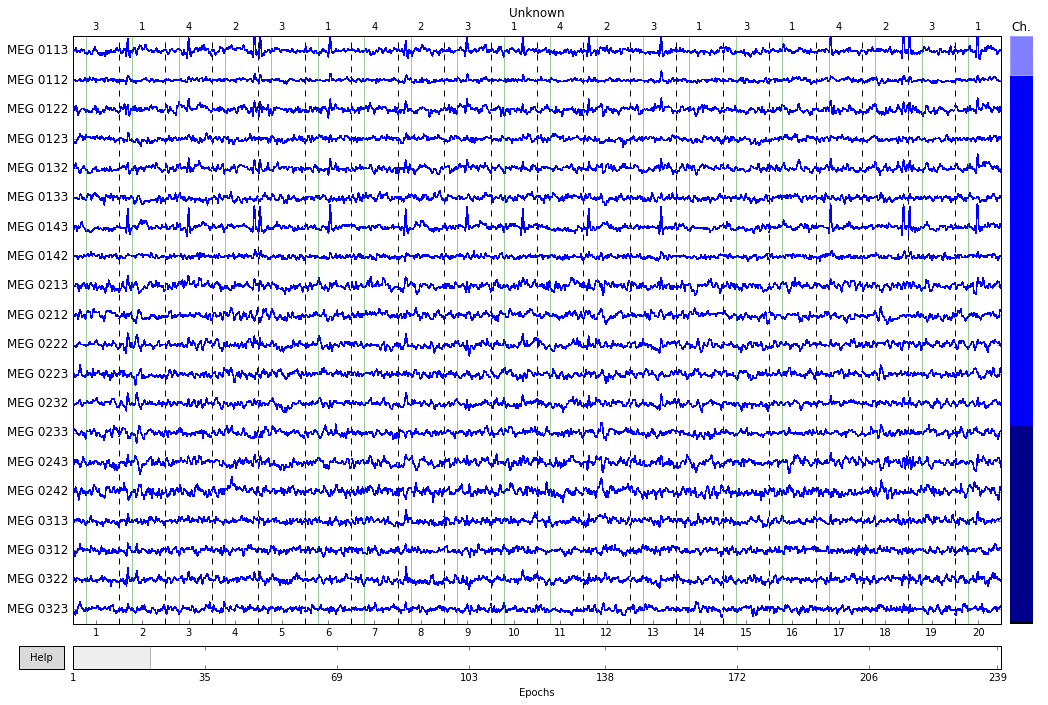

In [59]:
% matplotlib

epochs.plot()  # Google Summer of code 2015 with Jaakko Leppäkangas

## More diagnostic plotting

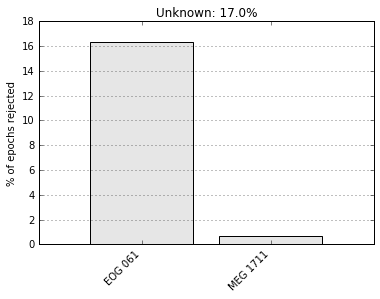

In [60]:
%matplotlib inline
epochs.drop_bad_epochs()
epochs.plot_drop_log();

In [63]:
for drop_log in epochs.drop_log[:20]:
    print(drop_log)

[u'EOG 061']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['IGNORED']
[u'EOG 061']
['IGNORED']
[]
[]


## basic IO 

The standard scenario is saving the epochs into .fif file together with all the header data.

In [65]:
epochs.save('sample-epo.fif')

Scipy also supports reading and writing of matlab files. You can save your single trials with:

In [60]:
from scipy import io
io.savemat('epochs_data.mat', dict(epochs_data=epochs.get_data()),
           oned_as='row')

### Average the epochs to get ERF/ERP and plot it!

In [69]:
% matplotlib inline

In [70]:
evoked = epochs.average()

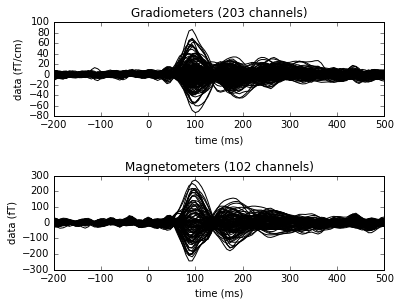

In [71]:
evoked.plot();

We can also show sensor position as line color:

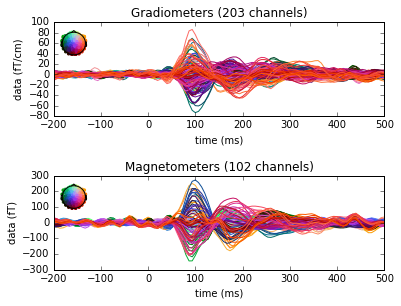

In [73]:
evoked.plot(spatial_colors=True);  # note the legend

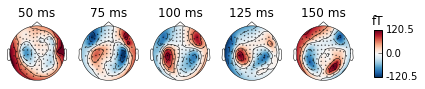

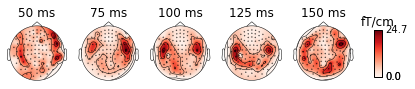

In [75]:
# pure topography plots
for ch_type in ('mag', 'grad'):
    evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type=ch_type);

Topoplot and time series can also be shown in one single plot:

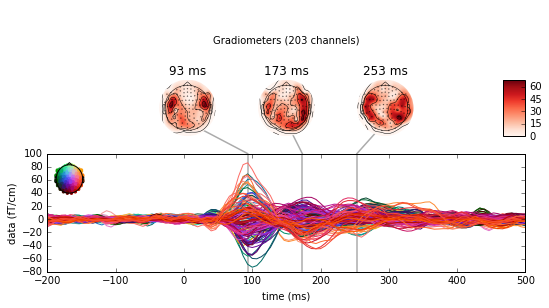

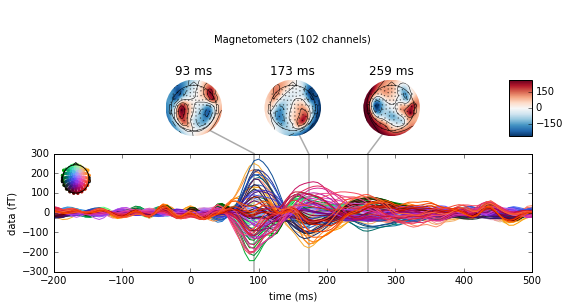

In [77]:
evoked.plot_joint();

## Important thing: access epochs by conditions condition

Syntax is `epochs[condition]`

In [80]:
epochs_data = epochs['visual/left'].get_data()
print(epochs_data.shape)

(67, 306, 106)


epochs_data is a 3D array of dimension (55 epochs, 365 channels, 106 time instants).

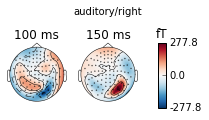

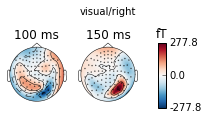

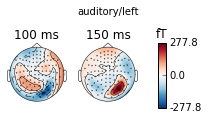

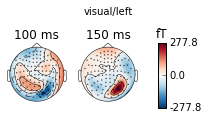

In [83]:
# Loop over conditions
for condition in event_id:
    epochs[k].average().plot_topomap(times=[0.1, 0.15], title=condition);

## Some Python + MNE Kung Fu to plot selected channels and conditions

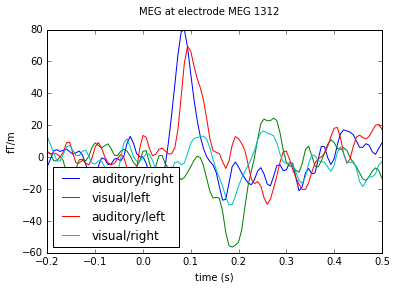

In [114]:
sensor = "MEG 1312"

evokeds = {k:epochs[k].average() for k in event_id}  # funny expression, no? Google "dict comprehension"

for condition, evoked in evokeds.items():  # that's what dictionaries are good for, looping!
    data = evoked.pick_channels([sensor], copy=True).data[0]
    plt.plot(evoked.times, data * 1e13, label=condition)

plt.legend(loc="lower left")
plt.ylabel("fT/m")
plt.xlabel("time (s)")
plt.suptitle("MEG at electrode {}".format(sensor))

In [92]:
# remember ...
event_id

{'auditory/left': 2, 'auditory/right': 1, 'visual/left': 3, 'visual/right': 4}

In event_id, "/" selects conditions in a hierarchical way, e.g. here, "auditory" vs. "visual", "left" vs. "right", and MNE can select them individually

In [93]:
print(epochs["visual"])

<Epochs  |  n_events : 123 (all good), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : (None, 0),
 'visual/left': 67, 'visual/right': 56>


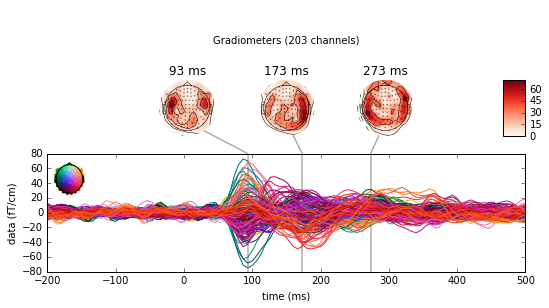

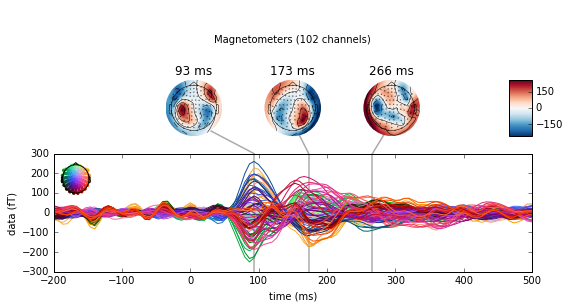

In [94]:
epochs["left"].average().plot_joint()

## Customize your plots
### wanna have every text in magenta?

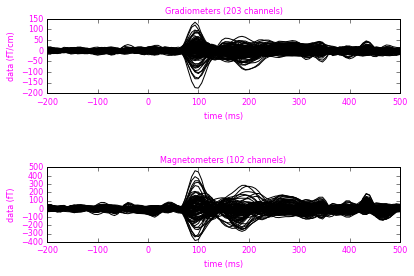

In [95]:
fig = evoked.plot(show=False)  # butterfly plots
fig.subplots_adjust(hspace=1.0)
for text in fig.findobj(mpl.text.Text):
    text.set_fontsize(8)
    text.set_color('magenta')
fig.savefig('plot_erf.pdf');

## Write evoked data to disk

In [99]:
evoked.save('sample-ave.fif')

or to write multiple conditions in 1 file

In [113]:
evokeds_list = [epochs[k].average() for k in event_id]  # get evokeds
mne.write_evokeds('sample-ave.fif', evokeds_list)

### Reading evoked from disk

It is also possible to read evoked data stored in a fif file:

In [106]:
evoked_fname = data_path + '/MEG/sample/sample_audvis-ave.fif'
evoked1 = mne.read_evokeds(evoked_fname, condition=0, baseline=(None, 0), proj=True)

Or another one stored in the same file:

In [107]:
evoked2 = mne.read_evokeds(evoked_fname, condition=1,
                           baseline=(None, 0), proj=True)

Or give the explicit name of the averaged condition:

In [110]:
evoked3 = mne.read_evokeds(evoked_fname, condition='Left Auditory',
                           baseline=(None, 0), proj=True)

Did you note that you can apply some preprocessing on reading the evokeds from disk?

### Compute a contrast:

In [115]:
contrast = evokeds["visual/left"] - evokeds["visual/right"]
# note that this combines evokeds in a weighted way
# so if you have imbalanced trial numbers, you might not get what you want
print(contrast)
mne.combine_evoked?

<Evoked  |  comment : 'visual/left - visual/right', kind : average, time : [-0.199795, 0.499488], n_epochs : 123, n_channels x n_times : 305 x 106>


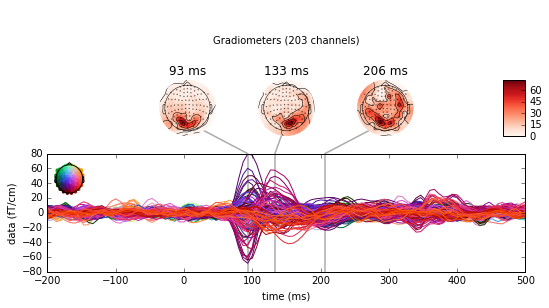

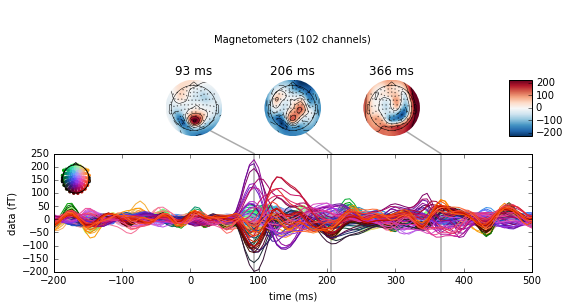

In [117]:
fig = contrast.plot_joint()

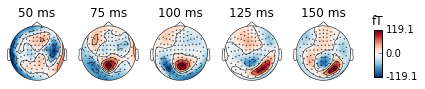

In [118]:
# will only work on MAC
%matplotlib qt4
import numpy as np
contrast.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type='mag')
plt.savefig('toto.pdf')
!open toto.pdf

### Save your figure as pdf

## Exercises

- Extract Epochs restricted to magnetometers on unfiltered data (sample_audvis_raw.fif)
- Construct epochs with a whole-epoch baseline. Then, filter raw data at 1 Hz, construct epochs from that. Compare the resulting Evokeds (filter vs. baseline)
- Plot the difference between all *visual* and all *auditory* stimulus presentations
- Recompute everything for EEG